In [73]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

In [74]:
data = pd.read_json('yelp_academic_dataset_business.json', lines = True)

In [75]:
data = data[data['city'] == "Las Vegas"]
len(data)

29370

In [76]:
n_data = data.drop(["hours", "city", "is_open", "address", "name", "postal_code", "state", "business_id"], axis=1)

In [77]:
cat_none_values = n_data[n_data["categories"].isnull()]
n_data = n_data.drop(cat_none_values.index,axis=0)

attr_none_values = n_data[n_data["attributes"].isnull()]
n_data = n_data.drop(attr_none_values.index,axis=0)

In [78]:
categories = [i.split(',') for i in n_data['categories']]

n_data['categories'] = categories
n_data['one_hot_enc_cat'] = n_data['categories'].apply(lambda x: ':'.join(x))
dummies = n_data['one_hot_enc_cat'].str.get_dummies(sep=':')

n_data = n_data.merge(dummies, left_index = True, right_index = True)

n_data.drop(['categories', 'one_hot_enc_cat'], axis=1, inplace=True)

In [79]:
n_data = n_data.join(pd.DataFrame(n_data['attributes'].to_dict()).T)
n_data.head()

,attributes,latitude,longitude,review_count,stars,& Probates,ATV Rentals/Tours,Acai Bowls,Accessories,Accountants,...,RestaurantsCounterService,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,Smoking,WheelchairAccessible,WiFi
7,"{'RestaurantsPriceRange2': '3', 'GoodForKids':...",36.099872,-115.074574,3,3.5,0,0,0,0,0,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
17,"{'OutdoorSeating': 'False', 'BusinessAcceptsCr...",36.100016,-115.128529,40,4.0,0,0,0,0,0,...,NaN,False,True,2,True,NaN,True,NaN,NaN,u'no'
18,{'BusinessAcceptsCreditCards': 'True'},36.116549,-115.088115,21,5.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,{'GoodForKids': 'True'},36.169993,-115.140685,38,4.5,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,"{'BikeParking': 'False', 'Ambience': '{'romant...",36.080168,-115.182756,107,4.0,0,0,0,0,0,...,NaN,NaN,True,2,True,NaN,NaN,NaN,NaN,NaN


In [80]:
split_attributes = []
for attributes in n_data["attributes"]:
    for k,v in attributes.items():
        if type(ast.literal_eval(v)) == dict:
            split_attributes.append(k)

In [81]:
split_attributes_u = np.unique(split_attributes)

In [82]:
for split in split_attributes_u:
    df = pd.DataFrame(n_data[split].apply(lambda x: ast.literal_eval(x) if type(x) == str else x).to_dict()).T
    df.columns = [split + '_' + str(col) for col in df.columns]
    n_data = n_data.join(df)

In [83]:
non_boolean = []
for attributes in data["attributes"]:
    if attributes == None:
        continue
    for k,v in attributes.items():
        v = ast.literal_eval(v)
        if type(v) is not bool and type(v) is not dict:
            non_boolean.append(k)
            
non_boolean_u = np.unique(non_boolean)

In [84]:
#find the columns that are in non_boolean but not in split_attributes_u
a = [x for x in non_boolean_u if x not in split_attributes_u]
#get dummies for each of these columns
dummies = [pd.get_dummies(n_data[attr], prefix=attr, prefix_sep='_') for attr in a]

dummies_df = pd.concat(dummies, axis=1)
n_data = pd.concat([n_data, dummies_df], axis=1)


#Drop the columns we don't need anymore
n_data.drop(['attributes'], axis=1, inplace=True)
n_data.drop(list(split_attributes_u), axis=1, inplace=True)
n_data.drop(a, inplace=True, axis=1)
n_data.head()

,latitude,longitude,review_count,stars,& Probates,ATV Rentals/Tours,Acai Bowls,Accessories,Accountants,Acne Treatment,...,WheelchairAccessible_False,WheelchairAccessible_None,WheelchairAccessible_True,WiFi_'free',WiFi_'no',WiFi_'paid',WiFi_None,WiFi_u'free',WiFi_u'no',WiFi_u'paid'
7,36.099872,-115.074574,3,3.5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,36.100016,-115.128529,40,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
18,36.116549,-115.088115,21,5.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,36.169993,-115.140685,38,4.5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,36.080168,-115.182756,107,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
#A lot of missing values since most businesses only have a few attributes and categories.
#Fill missing values with a number
n_data.fillna(2, inplace=True)

In [86]:
#Fixing instances of boolean strings
mapper = {"True":1, "False":0}
n_data.replace(mapper, inplace = True)

In [87]:
np.shape(n_data)

(25043, 2157)

## Exploring the data

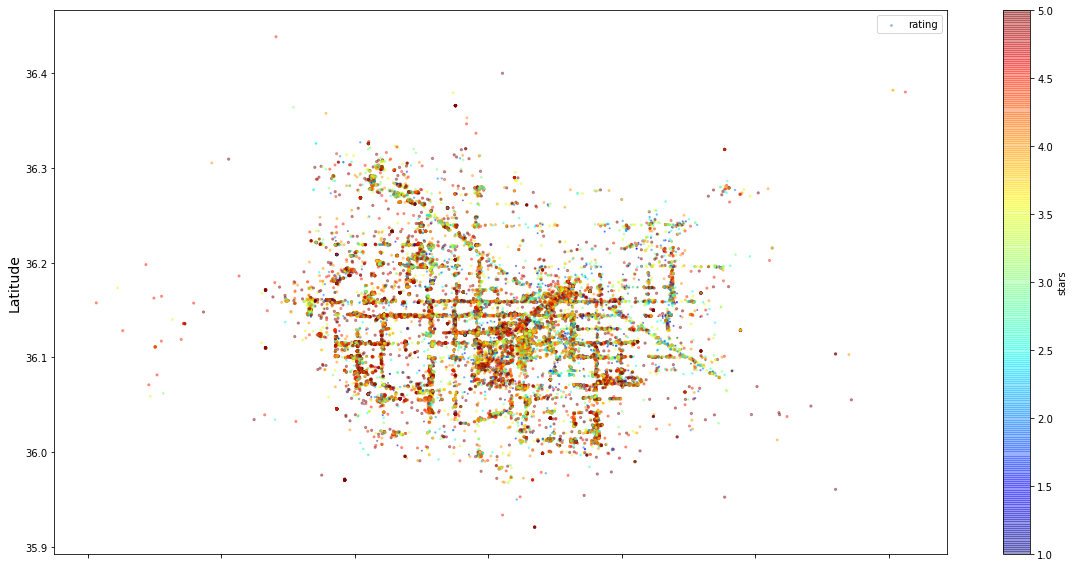

In [88]:
data.plot(kind="scatter", x="longitude", y="latitude",
    s=data['stars'], label="rating",
    c="stars", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(20,10),
)

plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend()
plt.show()

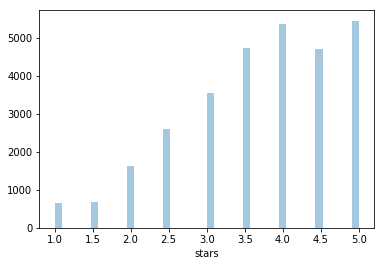

In [89]:
import seaborn as sns
sns.distplot(data['stars'], kde=False);

## Average star ratings by category for the highest- and lowest-rated business categories

[Text(0, 0, ' Apartments'),
 Text(0, 0, ' Banks & Credit Unions'),
 Text(0, 0, ' Taxis'),
 Text(0, 0, ' Post Offices'),
 Text(0, 0, ' Hospitals'),
 Text(0, 0, ' Internet Service Providers'),
 Text(0, 0, ' Fast Food'),
 Text(0, 0, ' Gastroenterologist'),
 Text(0, 0, ' Hostels'),
 Text(0, 0, ' Pharmacy'),
 Text(0, 0, ' Pan Asian'),
 Text(0, 0, ' Pulmonologist'),
 Text(0, 0, ' Drugstores'),
 Text(0, 0, ' Gas Stations'),
 Text(0, 0, ' Service Stations'),
 Text(0, 0, ' Talent Agencies'),
 Text(0, 0, ' Ear Nose & Throat'),
 Text(0, 0, ' Coffeeshops'),
 Text(0, 0, ' Laboratory Testing'),
 Text(0, 0, ' Psychiatrists'),
 Text(0, 0, ' Internal Medicine'),
 Text(0, 0, ' Employment Agencies'),
 Text(0, 0, ' Endocrinologists'),
 Text(0, 0, ' Bartenders'),
 Text(0, 0, ' Music Production Services'),
 Text(0, 0, ' Real Estate Photography')]

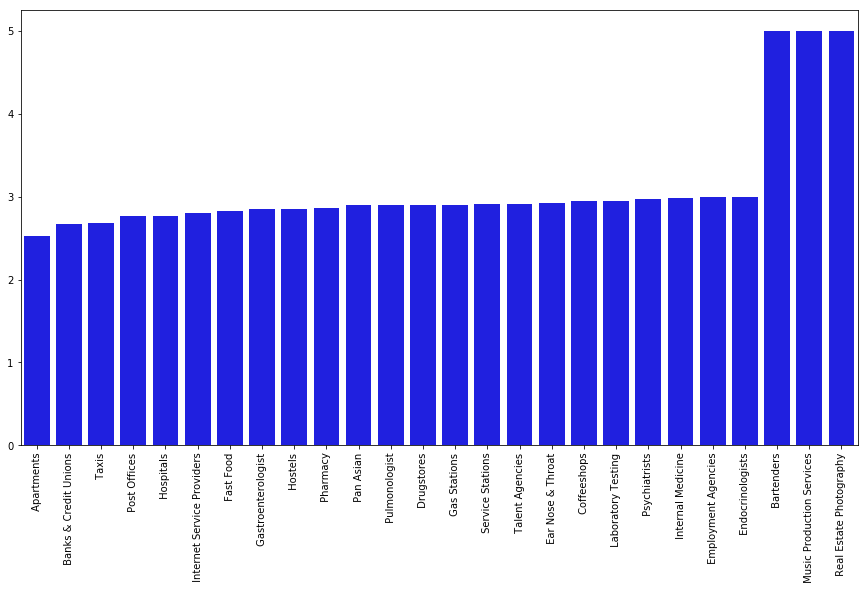

In [90]:
min_ratings = 5
categories = n_data.columns[14:1000].values  # category columns
upper_percentile = np.percentile(n_data['stars'], 85)
lower_percentile = np.percentile(n_data['stars'], 25)
cat_names = []
cat_means = []
for cat in categories:
    if n_data[n_data[cat] == 1].stars.value_counts().sum() >= min_ratings:
        curr_mean = n_data[n_data[cat] == 1].stars.mean()
        if curr_mean >= upper_percentile or curr_mean <= lower_percentile:
            cat_names.append(cat)
            cat_means.append(n_data[n_data[cat] == 1].stars.mean())


yx = sorted(zip(cat_means, cat_names))
y_sorted, x_sorted = zip(*yx)
plt.figure(figsize=(15,8))
ax = sns.barplot(x=x_sorted, y=y_sorted, color='b')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [91]:
categories1 = n_data.columns[3:].values
d = n_data.loc[0:, categories1]
df1 = d.replace(2, 0)
val = df1.groupby('stars').sum()
#print(val['BusinessAcceptsCreditCards_True'])
result = val.apply(lambda x: x.argmax(), axis=1)
print(result)
minIndex = val.apply(lambda x: x.argmin(), axis=1)
print(minIndex)

stars
0.0    BusinessAcceptsCreditCards_True
1.0    BusinessAcceptsCreditCards_True
1.5    BusinessAcceptsCreditCards_True
2.5    BusinessAcceptsCreditCards_True
3.0    BusinessAcceptsCreditCards_True
3.5    BusinessAcceptsCreditCards_True
4.0    BusinessAcceptsCreditCards_True
4.5    BusinessAcceptsCreditCards_True
5.0    BusinessAcceptsCreditCards_True
dtype: object
stars
0.0            & Probates
1.0            & Probates
1.5            & Probates
2.5            & Probates
3.0     ATV Rentals/Tours
3.5     ATV Rentals/Tours
4.0        Acne Treatment
4.5            & Probates
5.0          Aerial Tours
dtype: object


/Users/funkyapps/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  
/Users/funkyapps/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  


## Dimensionality reduction - PCA

In [92]:
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from scipy.sparse import csr_matrix
from math import sqrt

In [93]:
#Make the target values categorical by converting them to a score from 1-10
target = n_data["stars"].replace({
    0.5:1,
    1:2,
    1.5:3,
    2:4,
    2.5:5,
    3:6,
    3.5:7,
    4:8,
    4.5:9,
    5:10,
})
features = n_data.drop("stars", axis=1)

train_x, test_x, train_y, test_y = train_test_split(features, target, test_size=0.2, random_state=0)

## Logistic Regression with only sparse matrix

In [94]:
#Using sparse matrix
sp_train_x = csr_matrix(np.matrix(train_x, dtype=float))
sp_test_x = csr_matrix(np.matrix(test_x, dtype=float))

In [95]:
logisticRegr = LogisticRegression(solver = 'lbfgs', max_iter=5000)
logisticRegr.fit(sp_train_x, train_y)

predictions_lg = logisticRegr.predict(sp_test_x)

errors = abs(predictions_lg - test_y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors) / 2, 2), 'stars')
print('Accuracy:', logisticRegr.score(sp_test_x, test_y))

/Users/funkyapps/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Mean Absolute Error: 0.69 stars
Accuracy: 0.3028548612497505


## Logistic Regression with dimensionality reduction

In [96]:
svd = TruncatedSVD(100)
svd.fit(sp_train_x)

svd_train_x = svd.transform(sp_train_x)
svd_test_x = svd.transform(sp_test_x)

In [97]:
logisticRegr = LogisticRegression(solver = 'lbfgs', max_iter=1000)
logisticRegr.fit(svd_train_x, train_y)

predictions_lg = logisticRegr.predict(svd_test_x)

errors = abs(predictions_lg - test_y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors) / 2, 2), 'stars')
print('Accuracy:', logisticRegr.score(svd_test_x, test_y))

/Users/funkyapps/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Mean Absolute Error: 0.76 stars
Accuracy: 0.30804551806747854


## Logistic Regression with only Categories

In [98]:
#cats = list(itertools.chain.from_iterable(categories))
#cats = list(np.unique(cats))
#print(categories)
cats = list(categories)
cat_train_x = train_x[cats]
cat_test_x = test_x[cats]

cat_train_x = train_x[cats]
cat_test_x = test_x[cats]

sp_train_x = csr_matrix(np.matrix(cat_train_x, dtype=float))
sp_test_x = csr_matrix(np.matrix(cat_test_x, dtype=float))

In [99]:
svd = TruncatedSVD(100)
svd.fit(sp_train_x)

svd_train_x = svd.transform(sp_train_x)
svd_test_x = svd.transform(sp_test_x)

In [100]:
logisticRegr = LogisticRegression(solver = 'lbfgs', max_iter=1000)
logisticRegr.fit(svd_train_x, train_y)

predictions_lg = logisticRegr.predict(svd_test_x)

errors = abs(predictions_lg - test_y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors) / 2, 2), 'stars')
print('Accuracy:', logisticRegr.score(svd_test_x, test_y))

/Users/funkyapps/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Mean Absolute Error: 0.8 stars
Accuracy: 0.2685166699940108


## Logistic regression with only attributes

In [101]:
att_train_x = train_x.drop(cats + ["latitude", "longitude", "review_count"], axis=1)
att_test_x = test_x.drop(cats + ["latitude", "longitude", "review_count"], axis=1)
#train_x.drop(cats, axis=1)
#test_x.drop(cats, axis=1)

sp_train_x = csr_matrix(np.matrix(att_train_x, dtype=float))
sp_test_x = csr_matrix(np.matrix(att_test_x, dtype=float))

In [102]:
svd = TruncatedSVD(100)
svd.fit(sp_train_x)

svd_train_x = svd.transform(sp_train_x)
svd_test_x = svd.transform(sp_test_x)

In [103]:
logisticRegr = LogisticRegression(solver = 'lbfgs', max_iter=1000)
logisticRegr.fit(svd_train_x, train_y)

predictions_lg = logisticRegr.predict(svd_test_x)

errors = abs(predictions_lg - test_y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors) / 2, 2), 'stars')
print('Accuracy:', logisticRegr.score(svd_test_x, test_y))

/Users/funkyapps/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Mean Absolute Error: 0.8 stars
Accuracy: 0.2928728289079657


In [104]:
#Make the target values categorical by converting them to a score from 1-10
target = n_data["stars"].replace({
    0.5:1,
    1:2,
    1.5:3,
    2:4,
    2.5:5,
    3:6,
    3.5:7,
    4:8,
    4.5:9,
    5:10,
})
features = n_data.drop("stars", axis=1)

train_x, test_x, train_y, test_y = train_test_split(features, target, test_size=0.2, random_state=0)

## Random Forest Classifier sparse matrix

In [105]:
#Using sparse matrix
sp_train_x = csr_matrix(np.matrix(train_x, dtype=float))
sp_test_x = csr_matrix(np.matrix(test_x, dtype=float))

In [106]:
# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(sp_train_x, train_y)

predictions_rf = rf.predict(sp_test_x)

errors = abs(predictions_rf - test_y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors) / 2, 2), 'stars')
print('Accuracy:', rf.score(sp_test_x, test_y))

Mean Absolute Error: 0.7 stars
Accuracy: 0.3028548612497505


## Random Forest Classifier dimensionality reduction

In [107]:
svd = TruncatedSVD(100)
svd.fit(sp_train_x)

svd_train_x = svd.transform(sp_train_x)
svd_test_x = svd.transform(sp_test_x)

In [108]:
# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(svd_train_x, train_y)

predictions_rf = rf.predict(svd_test_x)

errors = abs(predictions_rf - test_y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors) / 2, 2), 'stars')
print('Accuracy:', rf.score(svd_test_x, test_y))

Mean Absolute Error: 0.74 stars
Accuracy: 0.295268516669994


## Random Forest Classifier only categories

In [112]:
cats = list(itertools.chain.from_iterable(categories))
cats = list(np.unique(cats))

cats = categories
cat_train_x = train_x[cats]
cat_test_x = test_x[cats]

cat_train_x = train_x[cats]
cat_test_x = test_x[cats]

sp_train_x = csr_matrix(np.matrix(cat_train_x, dtype=float))
sp_test_x = csr_matrix(np.matrix(cat_test_x, dtype=float))

In [113]:
svd = TruncatedSVD(100)
svd.fit(sp_train_x)

svd_train_x = svd.transform(sp_train_x)
svd_test_x = svd.transform(sp_test_x)

In [114]:
# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(svd_train_x, train_y)

predictions_rf = rf.predict(svd_test_x)

errors = abs(predictions_rf - test_y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors) / 2, 2), 'stars')
print('Accuracy:', rf.score(svd_test_x, test_y))

Mean Absolute Error: 0.79 stars
Accuracy: 0.2591335595927331


## Random Forest Classifier only attributes

In [116]:
#att_train_x = train_x.drop(cats + ["latitude", "longitude", "review_count"], axis=1)
#att_test_x = test_x.drop(cats + ["latitude", "longitude", "review_count"], axis=1)
#train_x.drop(cats, axis=1)
#test_x.drop(cats, axis=1)

sp_train_x = csr_matrix(np.matrix(att_train_x, dtype=float))
sp_test_x = csr_matrix(np.matrix(att_test_x, dtype=float))

In [117]:
svd = TruncatedSVD(100)
svd.fit(sp_train_x)

svd_train_x = svd.transform(sp_train_x)
svd_test_x = svd.transform(sp_test_x)

In [118]:
# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(svd_train_x, train_y)

predictions_rf = rf.predict(svd_test_x)

errors = abs(predictions_rf - test_y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors) / 2, 2), 'stars')
print('Accuracy:', rf.score(svd_test_x, test_y))

Mean Absolute Error: 0.79 stars
Accuracy: 0.2613296067079257
